# **Infer `Lysosomes`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

In notebooks 1.2 through 1.7, we will go over the implementation of `infer-subc` in the Napari plugin called  `organelle-segmenter-plugin`. The steps outlined in each notebook correlate to the workflow steps from the plugin. Here, you will gain knownledge of what `infer-subc` functions are involved in each of those steps.

The segmentation workflows are completely independent of each other and can be run in any order. The current notebook segments the `Lysosomes`. Notesbooks for the segmentation of other organelles can be found here:
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

***Note:** These notebooks do not include a batch processing option. They are simply explanations of the steps included in the Napari plugin. If you would like to batch process your images in a Jupyter notebook instead of the plugin, you can use: <mark> insert batch process segmentation notebook here </mark>*

### **Single cell analysis**
Each workflow segments organelles from the entire image, irrespective of the cell mask identified in notebook 1.1. To attain a single-cell analysis, the mask will be applied to the organelle segmentation outputs before quantification in the `part_2_quantification` notebooks. 

### **Lysosomes** 🗑️♻️
Lysosomes are membrane-enclosed structures that contain enzymes and an acidic lumen for breaking down cellular components such as proteins, other organelles, and more. Degradative cargo can be obtained through endocytosis, the secretory pathway, and fusion with autophagosomes. Lysosomes can also act as secretory vesicles and are involved in organelles contacts with many other intracellular organelles.

### **Fluorescence labeling strategies** 🔆 
Lysosomes can be fluorescently labeled in live and fixed cells by staining for endogenous proteins, targeting fluorescent proteins to the membrane or lumen using genertically encoded markers, or with dye-based approaches. The labeling approach used and resolution of your images can result in different staining outcomes that can impact the segmentation steps below. For example, a genetically encoded fluorescent protein targeted to lysosomes using the membrane-associated Lamp1 protein (e.g., Lamp1-GFP) will specifically label the lyososomal membrane, not the lumen. In this case, large lysosomes may appear as empty rings or shells. In contrast, if a luminal dye is used, the structures will likely appear as a filled-in circle or sphere. 

Additionally, it can be challenging to differentiate between closely related vesicles within the endolysosomal system, like late endososomes and lysosomes. Therefore, understanding the coverage of your chosen marker is important in understanding the biological implication of results derived from this pipeline. 

The workflow below is best suited for segmentation of filled-in lysosome structures. When membrane-based labeling methods are used, the hollow structures are not always able to be filled in during segmentation, and, in some cases, regions of the shell structure enclosing the lysosomes aren't bright enough to segmented completely. 

Lysosome shapes can be spherical or take on a more elongated tube shape, so two segmentation methods to identify the wide range of object shapes is included. Read through the steps below for more details.

***We advise that you test the segmentation process on a small, pilot dataset before committing to a particular labeling strategy and segmentation approach.***

-----

### 👣 **Summary of steps**  

➡️ **EXTRACTION**
- **`Step 1`** - Select a channel for segmentation

  - select single channel containing the lysosome marker (channel number = user input)

**PRE-PROCESSING**
- **`Step 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`Step 3`** - ‘Dot’ thresholding method (AICSSeg)

  - apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff, and method = user input)

- **`Step 4`** - ‘Filament’ threshold method (AICSSeg)

  - apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`Step 5`** - Combine Segmentations (logical or)

  - combine the two segmentations with logical *OR*

**POST-PROCESSING**
- **`Step 6`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`Step 7`** - Label objects

  - label unique lysosome objects based on connectivity

**EXPORT** ➡️
- save labeled ***lysosomes*** (lyso, LS) as unsigned integer 16-bit ".tiff" file

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files)
from infer_subc.core.img import *         

%load_ext autoreload
%autoreload 2

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [2]:
#### USER INPUT REQUIRED ###
im_type = ".czi"
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"
in_data_path = data_root_path / "raw"
out_data_path = data_root_path / "out"

#### &#x1F3C3; **Run code; no user input required**

In [3]:
# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

,Image Name
0,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\11252023_MSi08L_iPSCs_undiff_BR1_N20_Unmixing.czi
1,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_2_Unmixing.czi
2,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_3_Unmixing.czi
3,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_10_Unmixing.czi
4,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_4_Unmixing.czi
5,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
6,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_14_Unmixing.czi
7,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_01_Unmixing.czi
8,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_02_Unmixing.czi
9,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_07_Unmixing.czi


#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [4]:
#### USER INPUT REQUIRED ###
test_img_n = 5

#### &#x1F3C3; **Run code; no user input required**

In [5]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
Channel 0 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Nuclei_Jan22
Channel 1 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Lyso+405_Jan22
Channel 2 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Mito+405_Jan22
Channel 3 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Golgi+405_Jan22
Channel 4 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Peroxy+405_Jan22
Channel 5 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: ER+405_Jan22
Channel 6 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: BODIPY+405low_Jan22
Channel 7 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Residuals
Scale (ZYX): (0.3891184878080979, 0.07987165184837317, 0.07987165184837318)
Channel axis: 0


08-Feb-25 18:15:37 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1086x661+1532+206 (frame: 1104x708+1523+168) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 905x831+1530+199 (frame: 923x878+1521+161) margins: 9, 38, 9, 9 minimum size: 385x519 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,566 maxtrack=0,0)



Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

### **`STEP 1` - Select a channel for segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify which channel includes your lysosome label:
- `LYSO_CH`: the index of the channel containing your lysosome label. Image indexing beginning with 0, not 1. Reference the channel numbers indicated in the Napari window for easy reference.

In [6]:
#### USER INPUT REQUIRED ###
LYSO_CH = 1

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block extracts the lysosome channel from your multi- (or single) channel image. It will be the only part of the image used in the rest of this workflow. The single lysosome channel is added to the Napari viewer.

In [7]:
# select channel
raw_lyso = select_channel_from_raw(img_data, LYSO_CH)

# clear napari and add single channel as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.add_image(raw_lyso, scale=scale, name="1 - Extract Lyso")

<Image layer '1 - Extract Lyso' at 0x1b2be2f6320>

-----
## **PRE-PROCESSING**

### **`STEP 2` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

In [8]:
#### USER INPUT REQUIRED ###
med_filter_size = 3   
gaussian_smoothing_sigma = 1.34

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [9]:
# rescaling and smoothing input image
struct_img =  scale_and_smooth(raw_lyso,
                               median_size = med_filter_size, 
                               gauss_sigma = gaussian_smoothing_sigma)

# adding image to Napari as a new layer
viewer.add_image(struct_img, scale=scale, name="2 - Rescale and Smooth")

<Image layer '2 - Rescale and Smooth' at 0x1b2bf458310>

-----
## **CORE-PROCESSING**

### **`STEP 3` -  ‘Dot’ thresholding method (AICSSeg)**

&#x1F453; **FYI:** This code block is the first of two semantic segmentation steps that are combined together in a later step. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The 'dot' filter is derived from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. It utilizes up to three scale (object size) and cutoff (threshold) pairs for different size and intensity objects. This function is specifically designed to segment small round objects.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the scale and cutoff values for each pair:
- `dot_scale_1`: the size scale for the first scale/cutoff pair; larger values correlate to selection of larger objects
- `dot_cut_1`: the threshold cutoff value for the first scale/cutoff pair; small cutoffs tend to yield more dots that are larger in volume; larger cutoffs tend to yield less dots that are slimmer.
- `dot_scale_2`: the size scale for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `dot_cut_2`: the threshold cutoff value for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `dot_scale_3`: the size scale for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `dot_cut_3`: the threshold cutoff value for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `dot_method`: "3D" processes the image taking into account intensities in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering any intensity in higher or lower Z planes.

In [ ]:
#### USER INPUT REQUIRED ###
dot_scale_1 = 5
dot_cut_1 = 0.09

dot_scale_2 = 2.5
dot_cut_2 = 0.07

dot_scale_3 = 1
dot_cut_3 = 0.01

dot_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the dot filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: it is helpful to adjust the scale/cutoff filters one at a time and then combine them once each pair's settings are confirmed.*

In [63]:
# apply the 2D or 3D versions of the AICSsegmentation dot filter with multiple scales
bw_dot_test = dot_filter_3(struct_img,
                           dot_scale_1,
                           dot_cut_1,
                           dot_scale_2,
                           dot_cut_2,
                           dot_scale_3,
                           dot_cut_3,
                           dot_method)

# adding image to Napari as a new layer
viewer.add_image(bw_dot_test, scale=scale, name="3 - Dot filter", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '3 - Dot filter' at 0x19e3f2b5b10>

### **`STEP 4` - ‘Filament’ threshold method (AICSSeg)**

&#x1F453; **FYI:** This code block is the second semantic segmentation step that will be combined with the dot filter results.

The 'filament' filter is derived from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. It utilizes up to three scale (object size) and cutoff (threshold) pairs for different size and intensity objects. This function is specifically designed to segment filamentous or tubular objects.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the scale and cutoff values for each pair:
- `fil_scale_1`: the size scale for the first scale/cutoff pair; larger values correlate to selection of larger objects
- `fil_cut_1`: the threshold cutoff value for the first scale/cutoff pair; small cutoffs tend to yield more dots that are larger in volume; larger cutoffs tend to yield less dots that are slimmer.
- `fil_scale_2`: the size scale for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `fil_cut_2`: the threshold cutoff value for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `fil_scale_3`: the size scale for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `fil_cut_3`: the threshold cutoff value for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `fil_method`: "3D" processes the image taking into account intensities in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering any intensity in higher or lower Z planes.

In [12]:
#### USER INPUT REQUIRED ###
fil_scale_1 = 1
fil_cut_1 = 0.15

fil_scale_2 = 0
fil_cut_2 = 0

fil_scale_3 = 0
fil_cut_3 = 0

fil_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the filament filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: it is helpful to adjust sellect the scale/cutoff filters one at a time and then combine them once each pair's settings are confirmed.*

In [13]:
# apply the 2D or 3D versions of the AICSsegmentation filament filter with multiple scales
bw_filament_test = filament_filter_3(struct_img,
                                    fil_scale_1,
                                    fil_cut_1,
                                    fil_scale_2,
                                    fil_cut_2,
                                    fil_scale_3,
                                    fil_cut_3,
                                    fil_method)

# adding image to Napari as a new layer
viewer.add_image(bw_filament_test, scale=scale, name="4 - Filament filter", opacity=0.3, colormap="magenta", blending='additive')

<Image layer '4 - Filament filter' at 0x1b2bf1427d0>

### **`STEP 5` - Combine Segmentations**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block combines the dot and filament filter outputs together using the "logical or" operation. The resulting semantic segmentation can be viewed in Napari.

In [14]:
# combine the two segmentations together
bw_test = np.logical_or(bw_dot_test, bw_filament_test)

# adding image to Napari as a new layer
viewer.add_image(bw_test, scale=scale, name="5 - Combined Semantic Segmentation", colormap="green")

<Image layer '5 - Combined Semantic Segmentation' at 0x1b2c10aeef0>

-----
## **POST-PROCESSING**

### **`STEP 6` - Remove small holes and objects**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results is higher or lower Z planes.

In [15]:
#### USER INPUT REQUIRED ###
hole_min_width = 0
hole_max_width = 25

small_object_width = 2

fill_filter_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: white pixels/voxels are the one remaining after this step*

In [16]:
# fill holes and removed small objects
cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# adding image to Napari as a new layer
viewer.add_image(cleaned_img2, scale=scale, name="6 - Fill holes and remove small objects", colormap="magenta", blending="additive")

<Image layer '6 - Fill holes and remove small objects' at 0x1b2c2340a00>

-----
## **POST-POST-PROCESSING**

## **`STEP 7` - Label objects**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block takes the semantic segmentation and creates an `instance segmentation`. In this output, each individual object in the image is given a unique ID number. The background pixels/voxels are still labeled as 0, but now each pixle/voxel within an object is labeled as a positive integer. 

In this workflow objects are separated based on connectivity: if a pixel/voxel is touching another pixel/voxel in any direction, they are considered the same object and each pixel/voxel within that object is labeled as the same unique ID number. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color.*

In [17]:
# create instance segmentation based on connectivity
lysosome_labels = label_uint16(cleaned_img2)

# adding image to Napari as a new layer
viewer.add_labels(lysosome_labels, scale=scale, name="7 - Instance segmentation")

<Labels layer '7 - Instance segmentation' at 0x1b2ef6b6440>

-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [ ]:
# Saving file
out_file_n = export_inferred_organelle(lysosome_labels, "lyso", meta_dict, out_data_path)
print(f"saved to: {out_data_path}")

-----
-----
## **Define `infer_lyso()` function**
The following code includes an example of how the workflow steps above are combined into one function. This function can be run below to process a single image. It is included in the <mark>batch process notebook</mark> to run the above analysis on multiple cells. 

This function can utilized from infer-subc using:
```python
infer_subc.organelles.lysosome.infer_lyso()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_lyso()` function. It is applied below.

In [18]:
##########################
#  infer_lyso
##########################
def _infer_lyso(in_img: np.ndarray,
                lyso_ch: int,
                median_sz: int,
                gauss_sig: float,
                dot_scale_1: float,
                dot_cut_1: float,
                dot_scale_2: float,
                dot_cut_2: float,
                dot_scale_3: float,
                dot_cut_3: float,
                dot_method: str,
                fil_scale_1: float,
                fil_cut_1: float,
                fil_scale_2: float, 
                fil_cut_2: float, 
                fil_scale_3: float, 
                fil_cut_3: float,
                fil_method: str,
                min_hole_w: int,
                max_hole_w: int,
                small_obj_w: int,
                fill_filter_method: str ) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    fil_scale: 
        scale (log_sigma) for filament filter
    fil_cut: 
        threshold for filament fitered threshold
    min_hole_w: 
        hole filling min for nuclei post-processing
    max_hole_w: 
        hole filling cutoff for nuclei post-processing
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    fill_filter_method:
        to fill snall holes and remove small objects in "3D" or "slice-by-slice"

    Returns
    -------------
    lyso_object
        mask defined extent of lysosome object

    """
    ###################
    # EXTRACT
    ###################    
    lyso = select_channel_from_raw(in_img, lyso_ch)

     ###################
    # PRE_PROCESSING
    ###################    
    lyso1 =  scale_and_smooth(lyso,
                             median_size = median_sz, 
                             gauss_sigma = gauss_sig)
   ###################
    # CORE_PROCESSING
    ###################
    bw_dot = dot_filter_3(lyso1, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw_filament = filament_filter_3(lyso1, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    bw = np.logical_or(bw_dot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, hole_min=min_hole_w, hole_max=max_hole_w, min_size=small_obj_w, method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

The segmentation output here matches the output created above: True


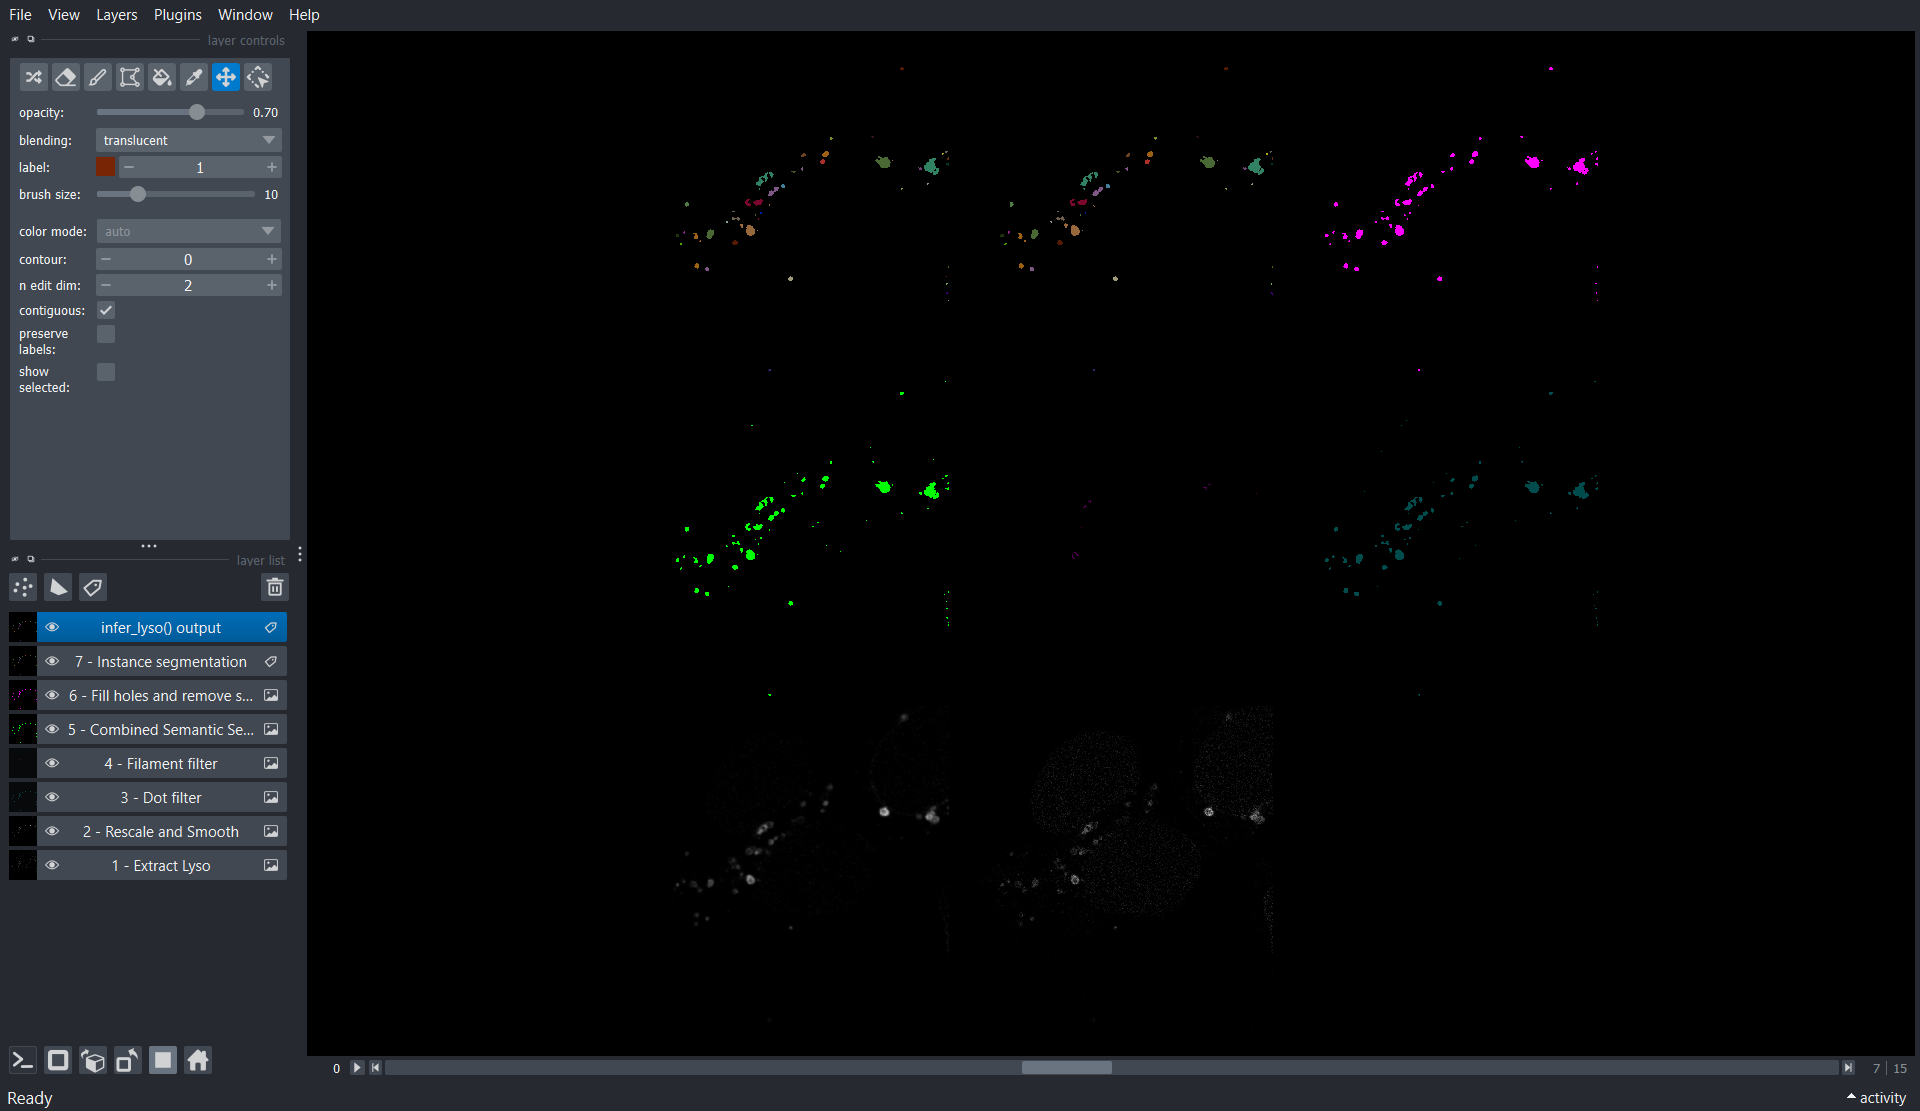

In [19]:
# run lysosome segmentation function
_lyso_object = _infer_lyso(  
        img_data,
        LYSO_CH,
        med_filter_size,
        gaussian_smoothing_sigma,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2,
        dot_scale_3,
        dot_cut_3,
        dot_method,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method)

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(lysosome_labels == _lyso_object)}")

# adding image to Napari as a new layer
viewer.add_labels(_lyso_object, scale=scale, name="infer_lyso() output")
viewer.grid.enabled = True
viewer.reset_view()

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

-------------
### ✅ **INFER LYSOSOMES COMPLETE!**

Continue on to other notebooks as needed:
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

Or proceed to batch processing here: <mark>link to batch notebook</mark>